# Support Vector Classifier

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE

pd.set_option('display.max_columns', 500)

/Users/johngalvin/miniforge3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [6]:
df = pd.read_csv('../data/clinical_training_data.csv')

# For converting categorical variables to ints
label_encoder = LabelEncoder()
scaler = MinMaxScaler()

# Split features / target
X = df.drop(columns=['AD_dx_in_5_yrs'])
y = df['AD_dx_in_5_yrs']

# Encode features
X["DX.bl"] = label_encoder.fit_transform(X["DX.bl"])
X["PTGENDER"] = label_encoder.fit_transform(X["PTGENDER"])
X["PTETHCAT"] = label_encoder.fit_transform(X["PTETHCAT"])
X["PTRACCAT"] = label_encoder.fit_transform(X["PTRACCAT"])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale data
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# SMOTE
smote = SMOTE(sampling_strategy="auto")
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Instantiate Model
svc = SVC()

### Grid Search

In [7]:
# Grid search
param_grid = {
    "C": [0.1, 1, 10],                
    "kernel": ["linear", "poly", "rbf", "sigmoid"],
    "gamma": ["scale", "auto", 0.1],
    "degree": [1, 2, 3, 4, 5]}

In [8]:
grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=5, scoring="accuracy")

In [9]:
grid_search.fit(X_resampled, y_resampled)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10], 'degree': [1, 2, 3, 4, 5],
                         'gamma': ['scale', 'auto', 0.1],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='accuracy')

In [10]:
# Get the best parameters and best accuracy score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Print the best parameters and best score
print("Best Parameters:", best_params)
print("Best Accuracy:", best_score)

Best Parameters: {'C': 1, 'degree': 5, 'gamma': 'scale', 'kernel': 'poly'}
Best Accuracy: 0.8308763886439781


### Train with Best Parameters

In [11]:
# Instantiate and fit model
svc = SVC(C=1, degree=5, gamma="scale", kernel="poly")

svc.fit(X_resampled, y_resampled)

SVC(C=1, degree=5, kernel='poly')

In [12]:
# Assess
y_pred = svc.predict(X_test)

# evaluate predictions
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.76      0.84        79
           1       0.46      0.80      0.58        20

    accuracy                           0.77        99
   macro avg       0.70      0.78      0.71        99
weighted avg       0.84      0.77      0.79        99



# Neural Network

In [13]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from imblearn.over_sampling import SMOTE

tf.config.run_functions_eagerly(True)

In [14]:
df = pd.read_csv('../data/clinical_training_data.csv')

# For converting categorical variables to ints
label_encoder = LabelEncoder()
scaler = MinMaxScaler()

# Split features / target
X = df.drop(columns=['AD_dx_in_5_yrs'])
y = df['AD_dx_in_5_yrs']

# Encode features
X["DX.bl"] = label_encoder.fit_transform(X["DX.bl"])
X["PTGENDER"] = label_encoder.fit_transform(X["PTGENDER"])
X["PTETHCAT"] = label_encoder.fit_transform(X["PTETHCAT"])
X["PTRACCAT"] = label_encoder.fit_transform(X["PTRACCAT"])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale data
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# SMOTE
smote = SMOTE(sampling_strategy="auto")
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [15]:
IN_FEATURES = X_train[0].shape[0]

In [16]:
def create_model(dropout=0.3, learning_rate=0.0001):
    
    """Builds classification model"""
    
    model = tf.keras.Sequential()
    inputs = tf.keras.layers.Input(shape=(IN_FEATURES,), name="input_layer") # (Batch, num_features)
    
    hidden_1 = tf.keras.layers.Dense(512, activation="relu", name="hidden_1")(inputs)
    hidden_1 = tf.keras.layers.Dropout(dropout)(hidden_1)
    hidden_2 = tf.keras.layers.Dense(256, activation="relu", name="hidden_2")(hidden_1)
    hidden_2 = tf.keras.layers.Dropout(dropout)(hidden_2)
    
    classification = tf.keras.layers.Dense(1, activation="sigmoid", name="classification_layer")(hidden_2)
    classification_model = tf.keras.Model(inputs=[inputs], outputs=[classification])
    
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
                                 metrics="accuracy")

    return classification_model

In [17]:
model = create_model()

Metal device set to: Apple M2 Pro


2023-10-02 09:30:51.730907: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-10-02 09:30:51.730981: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [18]:
history = model.fit(X_resampled,
                    y_resampled,
                    batch_size=16,
                    epochs=20)

Epoch 1/20


/Users/johngalvin/miniforge3/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
2023-10-02 09:30:52.003272: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
/Users/johngalvin/miniforge3/lib/python3.9/site-packages/keras/backend.py:5676: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


34/34 [==============================] - 1s 25ms/step - loss: 0.6827 - accuracy: 0.5921
Epoch 2/20
34/34 [==============================] - 1s 21ms/step - loss: 0.6407 - accuracy: 0.7425
Epoch 3/20
34/34 [==============================] - 1s 24ms/step - loss: 0.5981 - accuracy: 0.7744
Epoch 4/20
34/34 [==============================] - 1s 23ms/step - loss: 0.5528 - accuracy: 0.7951
Epoch 5/20
34/34 [==============================] - 1s 21ms/step - loss: 0.5200 - accuracy: 0.8026
Epoch 6/20
34/34 [==============================] - 1s 21ms/step - loss: 0.4930 - accuracy: 0.7932
Epoch 7/20
34/34 [==============================] - 1s 21ms/step - loss: 0.4684 - accuracy: 0.8139
Epoch 8/20
34/34 [==============================] - 1s 21ms/step - loss: 0.4555 - accuracy: 0.7951
Epoch 9/20
34/34 [==============================] - 1s 21ms/step - loss: 0.4440 - accuracy: 0.7970
Epoch 10/20
34/34 [==============================] - 1s 21ms/step - loss: 0.4474 - accuracy: 0.7989
Epoch 11/20
34/34 [=

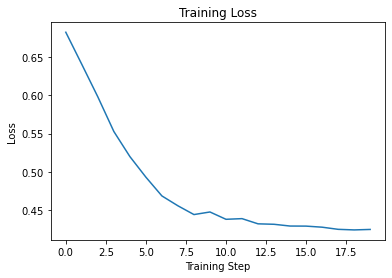

In [19]:
# Visualize loss curve

losses = history.history["loss"]
plt.plot(losses)
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

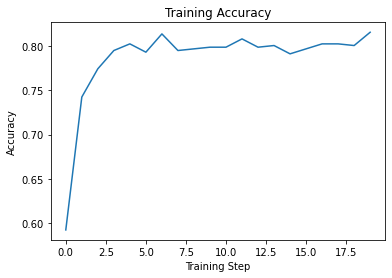

In [20]:
# Visualize accuracy curve

losses = history.history["accuracy"]
plt.plot(losses)
plt.xlabel("Training Step")
plt.ylabel("Accuracy")
plt.title("Training Accuracy")
plt.show()

In [21]:
model.evaluate(X_test, y_test)

4/4 [==============================] - 0s 22ms/step - loss: 0.4891 - accuracy: 0.7273


[0.4891086220741272, 0.7272727489471436]

In [22]:
preds = model.predict(X_test)
preds

4/4 [==============================] - 0s 4ms/step


array([[0.06204857],
       [0.5645148 ],
       [0.7192468 ],
       [0.03715334],
       [0.76087755],
       [0.792556  ],
       [0.42499614],
       [0.2953972 ],
       [0.02766663],
       [0.06094112],
       [0.40384668],
       [0.5940333 ],
       [0.41700128],
       [0.03182071],
       [0.6914573 ],
       [0.04605116],
       [0.70730776],
       [0.01564723],
       [0.4725941 ],
       [0.5203284 ],
       [0.49514875],
       [0.0179326 ],
       [0.6972763 ],
       [0.04689747],
       [0.01658665],
       [0.01911455],
       [0.12015694],
       [0.76597214],
       [0.01605178],
       [0.01598399],
       [0.6935486 ],
       [0.04026412],
       [0.34863123],
       [0.79870635],
       [0.8855331 ],
       [0.04133075],
       [0.01853592],
       [0.02042908],
       [0.63452154],
       [0.89160866],
       [0.03033729],
       [0.6460805 ],
       [0.02840774],
       [0.66395724],
       [0.5084336 ],
       [0.02716413],
       [0.04360314],
       [0.030